In [11]:


package = ['boto3','es_lemmatizer','pyodbc','prince']
f= open("paquetes.txt","w+")

def install_txt(package):
  f= open("paquetes.txt","w+")
  for i in package:
    print(i)
    

    try:
        __import__(i)
        print('ya instalado {}'.format(i))
    except ImportError:
        # main(['install', package]) 
        f.write("{} \r\n".format(i))
        print('No instalado {}'.format(i))


install_txt(package)  
  

boto3
ya instalado boto3
es_lemmatizer
ya instalado es_lemmatizer
pyodbc
ya instalado pyodbc
prince
No instalado prince


In [12]:
!pip install -r paquetes.txt

**CONEXIÓN A LA FUENTE DE DATOS Y ANÁLISIS EXPLORATORIO (OPERACIONES FINANCIERAS-CUENTAS POR PAGAR)**

#**Librerias**

In [14]:
#Librerias
import re
import numpy as np
import pandas as pd
import pandas_profiling
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import unicodedata
from es_lemmatizer import lemmatize
import spacy
import re
import pyodbc
import prince
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**Rutas**

In [ ]:
#RUTAS
#OF :Operaciones financieras
#P : Personal

# Campaña_OF = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCF - Cuentas por pagar.xlsx')
# Campaña_P = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCP - Beneficio Educativo.xlsx')


In [15]:
#Rutas en Drive colab
os.getcwd()

'/content'

In [17]:
Campaña_OF =  "/content/Modelo Analítico PCF - Cuentas por pagar.xlsx"
Campaña_P  = "/content/Modelo Analítico PCP - Beneficio Educativo.xlsx"

#**Funciones**

In [37]:
# CONEXION A SERVIDOR ###################################################################################
# def Conexion():
#     server = '172.27.48.148'
#     #database = 'bdcmp_NuevaEpsCrm' 
#     username = 'CienciaDatos' 
#     password = 'C13nc1aD47*5'  
#     cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';UID='+username+';PWD='+ password)
#     cursor = cnxn.cursor()
#     return cnxn


# DEFINICION DE PICOS Y FECHAS ##################################################################################
##Se definen fechas para realizar los respectivos filtros 
##cuando se extraiga la información correspondiente desde el servidor

def fechas(df_Tipo_OF):
    df_OF = df_Tipo_OF.astype(str).replace('NaT','20200101')
#######Operaciones financieras
    df_OF ['fecha_ini_1'] = df_OF['Picos de demanda  1'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_1'] = ['20210401','20210301','20210301','20210301', '20210301', '20210301', '20210401']
    df_OF ['fecha_ini_2'] = df_OF['Picos de demanda  2'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_2'] = ['20210501', '20210501', '20200101', '20210501', '20200101', '20210501', '20201001']
    df_OF ['fecha_ini_3'] = df_OF['Picos de demanda  3'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_3'] = ['20210601', '20200101', '20200101', '20210601', '20200101', '20200101', '20210101']
    
    return df_OF  

## EXTRACCIÓN ########################################################################################################

def Extraccion(df_fechas, df_General, picos):
    #df_fechas : Nombre de la tabla con las tipologias seleccionadas y las fechas definidas correspondientes (con la función de fechas)
    #df_general : Nombre de tabla para cada campaña sin las fechas definidas 
    #picos : Número máximo de picos que se analizan [en OF son 2, en P son 3]
    
    query_base = "SELECT * FROM [172.27.90.50].[Ecopetrol_Reporting].[dbo].[Tbl_Ecopetrol_ResultadoBackOffice] "
    
    i = 0 
    cnxn = Conexion()
    query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas['fecha_ini_1'][i]+ "' AND '" + df_fechas['fecha_fin_1'][i] +"')"  
    query_completa = query_base + query
    df_inicial = pd.read_sql(query_completa, cnxn)

    for j in range(1,picos+1):
        df_General["Datos_Pico_"+str(j)] = 0
        for i in range(0,len(df_fechas['Campaña'])):
            cnxn = Conexion()
            query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas["fecha_ini_"+str(j)][i]+ "' AND '" + df_fechas["fecha_fin_"+str(j)][i] +"')"  
            query_completa = query_base + query
            df = pd.read_sql(query_completa, cnxn)
            df_total = pd.concat([df_inicial,df]).drop_duplicates()
            df_inicial = df_total
            df_General["Datos_Pico_"+str(j)][i] = df.shape[0] 
    print('Total de registros:', df_inicial.shape[0])
    print('Total de columnas:', df_inicial.shape[1])
            
    return df_total,df_General                 

# VALORES FALTANTES ###############################################################################################################################################################################################

def Valores_Faltantes(df, porcentaje):
    Faltantes = df.isnull().sum()
    df_Faltantes = pd.DataFrame({'Nombre_Columnas':Faltantes.index, 'Total_Vacios':Faltantes.values})#[df_Faltantes['Total_Vacios'] != 0]
    df_Faltantes = df_Faltantes[df_Faltantes['Total_Vacios'] != 0]

    df_Faltantes['Porcentaje_vacio'] = ((df_Faltantes['Total_Vacios']/df.shape[0])*100).round(2)
    df_Faltantes['Columna_vacia'] = 'NO'
    df_Faltantes.loc[df_Faltantes['Total_Vacios'] == df.shape[0], 'Columna_vacia'] = 'SI'
    
    print('Total columnas con valores faltantes :', df_Faltantes.shape[0])
    print('Total columnas vacias :', df_Faltantes[df_Faltantes['Columna_vacia'] == 'SI'].Columna_vacia.count())
    print('Total columnas no vacias con mas del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    #print('Total columnas no vacias con menos del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    
    return df_Faltantes

# ELIMINAR COLUMNAS##############################################################################################

#para eliminar columnas seleccionadas
def Eliminar_columnas(df, lista_columnas):
    df_drop = df.drop(columns = lista_columnas)
    print ('Cantidad de columnas iniciales : ', df.shape[1])
    print ('Cantidad despues de eliminar : ', df_drop.shape[1] )
    return df_drop
# columnas duplicadas
def columnas_dup(df):
    df_dup = df.T.duplicated().T
    return df_dup
#Para eliminar columnas duplicadas
def columnas_nodup(df):
    print ('Total de columnas antes de eliminar dup: ', df.shape[1])
    df_sindup = df.T.drop_duplicates().T
    print ('Total de columnas duplicadas : ', df.shape[1] - df_sindup.shape[1])
    print ('Total de columnas no duplicadas:', df_sindup.shape[1])
    return df_sindup    

def mytable(data):
    nulls = pd.DataFrame(data.isnull().sum()/data.shape[0]*100, columns=['% de datos nulos'])
    ceros = pd.DataFrame((data==0).sum()/data.shape[0]*100, columns=['% de ceros'])
    tipo = pd.DataFrame(data.dtypes,columns=['Tipo de datos'])
    val = pd.DataFrame(data.nunique(),columns=['# de valores diferentes'])
    valpor = pd.DataFrame(data.nunique()/data.shape[0]*100,columns=['% de valores diferentes'])
    mis_val_table = pd.concat([nulls, ceros,tipo, val, valpor], axis=1)
    return mis_val_table

**CAMPAÑA OPERACIONES FINACIERAS - CUENTAS POR PAGAR**

# **EXTRACCIÓN**

## **Definición de Tipologías y meses que se extraeran**

Se extrae tabla producto del entendimiento del negocio donde se encuentran definidas las tipologias y meses donde se presentaron los picos a estudiar

In [18]:
df_Tipo_OF =  pd.read_excel(Campaña_OF, sheet_name = '2. Esquema Tipologías de Servic', usecols = "B:H", skiprows= lambda x: x in [0, 1]).astype(str).replace('NaT','0') 

-- Campaña Operaciones financieras

In [19]:
df_Tipo_OF

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda 1,Picos de demanda 2,Picos de demanda 3
0,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,2021-03-01,2021-04-01,2021-05-01
1,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Endoso de facturas,2021-02-01,2021-04-01,0
2,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Pagos bloqueados,2021-02-01,0,0
3,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Radicación de facturas,2021-02-01,2021-04-01,2021-05-01
4,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Consultas retenciones aplicadas,2021-02-01,0,0
5,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Retención en Garantía,2021-02-01,2021-04-01,0
6,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Información y Seguimiento a usuarios en página...,2021-03-01,2020-09-01,2020-12-01


Se definen fechas de los picos en cada tipologia con el fin de realizar el posterior filtro 

In [20]:
df_fechas_OF = fechas(df_Tipo_OF)

In [21]:
df_fechas_OF

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda 1,Picos de demanda 2,Picos de demanda 3,fecha_ini_1,fecha_fin_1,fecha_ini_2,fecha_fin_2,fecha_ini_3,fecha_fin_3
0,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,2021-03-01,2021-04-01,2021-05-01,20210301,20210401,20210401,20210501,20210501,20210601
1,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Endoso de facturas,2021-02-01,2021-04-01,0,20210201,20210301,20210401,20210501,20200101,20200101
2,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Pagos bloqueados,2021-02-01,0,0,20210201,20210301,20200101,20200101,20200101,20200101
3,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Radicación de facturas,2021-02-01,2021-04-01,2021-05-01,20210201,20210301,20210401,20210501,20210501,20210601
4,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Consultas retenciones aplicadas,2021-02-01,0,0,20210201,20210301,20200101,20200101,20200101,20200101
5,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Retención en Garantía,2021-02-01,2021-04-01,0,20210201,20210301,20210401,20210501,20200101,20200101
6,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Información y Seguimiento a usuarios en página...,2021-03-01,2020-09-01,2020-12-01,20210301,20210401,20200901,20201001,20201201,20210101


## **Conexión y extracción de la información base**

In [ ]:
# %%time
# # Extraccion de la base con los filtros correspondientes
# df_Registros_OF = Extraccion(df_fechas_OF, df_Tipo_OF, 3)[0]
# # Tipologias seleccionadas e información general
# df_General_OF = Extraccion(df_fechas_OF, df_Tipo_OF, 3)[1]


<ipython-input-15-7702c8b73a20>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_General["Datos_Pico_"+str(j)][i] = df.shape[0]


Total de registros: 11224
Total de columnas: 222
Total de registros: 11224
Total de columnas: 222
Wall time: 7min 14s


Tabla con información general de lo que se extrajo por tipologia y pico

In [ ]:
df_General_OF['total'] = df_General_OF['Datos_Pico_1'] + df_General_OF['Datos_Pico_2'] + df_General_OF['Datos_Pico_3']

In [ ]:
df_General_OF 

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda 1,Picos de demanda 2,Picos de demanda 3,Datos_Pico_1,Datos_Pico_2,Datos_Pico_3,total
0,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,2021-03-01,2021-04-01,2021-05-01,3628,2327,1984,7939
1,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Endoso de facturas,2021-02-01,2021-04-01,0,113,68,0,181
2,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Pagos bloqueados,2021-02-01,0,0,51,0,0,51
3,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Radicación de facturas,2021-02-01,2021-04-01,2021-05-01,778,340,339,1457
4,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Consultas retenciones aplicadas,2021-02-01,0,0,102,0,0,102
5,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Retención en Garantía,2021-02-01,2021-04-01,0,93,40,0,133
6,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Información y Seguimiento a usuarios en página...,2021-03-01,2020-09-01,2020-12-01,683,445,233,1361


In [ ]:
df_Registros_OF.to_csv('Base_registros_extraida_OF.csv', index = False)

# **REVISIÓN Y LIMPIEZA**

## **Pefilamiento inicial**

In [23]:
#Lectura
df_Registros_OF = pd.read_csv('Base_registros_extraida_OF.csv')
df_Registros_OF.head(2)

,fgs_IdCampana,fgs_IdGestion,fgs_IdGestionDetalle,fgs_NombreCampana,fgs_NombrePlataforma,fgs_SiglasDocumentoContacto,fgs_NombreDocumentoContacto,fgs_NumeroDocumContacto,fgs_NombreCompletoContacto,fgs_FechaNacimientoContacto,fgs_HabeasContacto,fgs_NombreGeneroContacto,fgs_RoutingPointOrVdn,fgs_Extension,fgs_CallId,fgs_Skill,fgs_Ani,fgs_Ip,fgs_OpcionesIVR,fgs_FechaInicio,fgs_FechaFin,fgs_IdTipificacionGestionDetalle,fgs_Tipificación,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Nivel5,fgs_Nivel6,fgs_Nivel7,fgs_Nivel8,fgs_Nivel9,fgs_Nivel10,fgs_Direccion_01,fgs_BarrioDireccion_01,fgs_LocalidadDireccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,...,T_Objetivo_Total,T_Real_Total,Cumple_Objetivo_Total,fdp_IdHistoricoPqrGestionActual,fdp_IdGrupoGestionActual,fdp_NombreGrupoGestionActual,fdp_IdDetalleFlujoGestionActual,fdp_IdUsuarioGestionActual,fdp_UsuarioGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,CodigoGrupoRolGestionActual,GrupoRolGestionActual,fdp_MotivoGestionActual,fdp_NivelGestionActual,Ajustado,TipoAjuste,Valido,Pruebas,fdp_FechaVencimientoTotal,NoReprocesar,fdp_IdHistoricoPqrEscalamientoN4,fdp_IdGrupoEscalamientoN4,fdp_NombreGrupoEscalamientoN4,fdp_IdDetalleFlujoEscalamientoN4,fdp_IdUsuarioEscalamientoN4,fdp_UsuarioEscalamientoN4,fdp_NombreUsuarioEscalamientoN4,fgs_ObservacionEscalamientoN4,fdp_FechaEscalamientoN4,fdp_FechaVencimientoEscalamientoN4,CodigoGrupoRolEscalamientoN4,GrupoRolEscalamientoN4,fdp_MotivoEscalamientoN4,fdp_NivelEscalamientoN4,T_Objetivo_EnNivel4,T_Real_EnNivel4,Cumple_Objetivo_EnNivel4
0,12,14051976,1111309.0,Operaciones Financieras,Web,NIT,NaN,9003104584,METROOMAT NDT SAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.27.90.93,NaN,2021-03-01 06:08:30.000,2021-03-01 06:10:58.000,7367,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,NaN,NaN,NaN,NaN,NaN,NaN,CR 52 44 A 35,NaN,NaN,"BOGOTA, D.C.",BOGOTA,Colombia,8023687,...,NaN,NaN,NaN,4.0,0,Grupo Primer Nivel Operaciones Financieras,NaN,147.0,1.026290e+09,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,2021-03-01 06:10:58.000,2020-02-25 16:30:00.000,1.0,Asesor de Servicio Contact Center,NaN,Nivel1,True,Fecha Superior a la fecha de creación o Fecha ...,NaN,False,2021-03-01 09:45:00.000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No Aplica
1,12,14052000,1111345.0,Operaciones Financieras,Web,NIT,NaN,9001358397,CGG SERVICES SUCUSAL COLOMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.27.90.93,NaN,2021-03-01 06:15:54.000,2021-03-01 06:27:09.000,7367,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,NaN,NaN,NaN,NaN,NaN,NaN,AV CR 45 108 A 50 P 6,NaN,NaN,"BOGOTA, D.C.",BOGOTA,Colombia,7430946,...,NaN,NaN,NaN,4.0,0,Grupo Primer Nivel Operaciones Financieras,NaN,103.0,1.012361e+09,JEIMY YOLIMA ARDILA PINZON,Se solicita filtro de seguridad,2021-03-01 06:27:09.000,2020-02-25 16:30:00.000,8.0,Asesor de Servicio BackOffice Contact Center,NaN,Nivel1,True,Fecha Superior a la fecha de creación o Fecha ...,NaN,False,2021-03-01 09:45:00.000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No Aplica


In [40]:
tabla=mytable(df_Registros_OF)
display(tabla,df_Registros_OF.shape)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.008909
fgs_IdGestion,0.000000,0.000000,int64,11224,100.000000
fgs_IdGestionDetalle,0.000000,0.000000,float64,11224,100.000000
fgs_NombreCampana,0.000000,0.000000,object,1,0.008909
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.008909
...,...,...,...,...,...
fdp_MotivoEscalamientoN4,100.000000,0.000000,float64,0,0.000000
fdp_NivelEscalamientoN4,100.000000,0.000000,float64,0,0.000000
T_Objetivo_EnNivel4,100.000000,0.000000,float64,0,0.000000
T_Real_EnNivel4,7.733428,92.266572,float64,1,0.008909


(11224, 222)

In [41]:
tabla.describe(percentiles=[.05,0.25,0.5,.75,.95])

,% de datos nulos,% de ceros,# de valores diferentes,% de valores diferentes
count,222.000000,222.000000,222.000000,222.000000
mean,52.248078,4.764525,714.112613,6.362372
std,48.202681,20.593389,2422.086736,21.579533
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,92.489309,0.000000,2.000000,0.017819
75%,100.000000,0.000000,15.750000,0.140324
95%,100.000000,7.623842,8158.000000,72.683535
max,100.000000,100.000000,11224.000000,100.000000


In [36]:
vacios = tabla[tabla['% de datos nulos']==100]
vacios

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_NombreDocumentoContacto,100.0,0.0,float64,0,0.0
fgs_FechaNacimientoContacto,100.0,0.0,float64,0,0.0
fgs_HabeasContacto,100.0,0.0,float64,0,0.0
fgs_NombreGeneroContacto,100.0,0.0,float64,0,0.0
fgs_RoutingPointOrVdn,100.0,0.0,float64,0,0.0
...,...,...,...,...,...
CodigoGrupoRolEscalamientoN4,100.0,0.0,float64,0,0.0
GrupoRolEscalamientoN4,100.0,0.0,float64,0,0.0
fdp_MotivoEscalamientoN4,100.0,0.0,float64,0,0.0
fdp_NivelEscalamientoN4,100.0,0.0,float64,0,0.0


In [42]:
cardinalidad = tabla[tabla['% de valores diferentes']==100]
cardinalidad

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdGestion,0.0,0.0,int64,11224,100.0
fgs_IdGestionDetalle,0.0,0.0,float64,11224,100.0


In [ ]:
# profile = df_Registros_OF.profile_report(title = 'Pandas Profiling Report', correlations={"cramers": {"calculate": False}})
# profile.to_file(output_file = 'Perfilamiento_BaseInicial_CuentasPorPagar.html')

In [44]:
df_Registros_OF = df_Registros_OF[df_Registros_OF['fgs_Nivel1'] != 'Prestador de Servicios de Salud']
# se fue solo un dato y estefania lo borro.

## **Valores faltantes**

### **Columnas con valores faltantes**

In [45]:
df_Faltantes_OF = Valores_Faltantes(df_Registros_OF, 50)

Total columnas con valores faltantes : 159
Total columnas vacias : 77
Total columnas no vacias con mas del 50% de valores faltantes : 37


In [46]:
df_Faltantes_OF[(df_Faltantes_OF['Porcentaje_vacio'] >= 50) & (df_Faltantes_OF['Columna_vacia'] == 'NO')]

,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
51,ude_CodUni,11072,98.65,NO
52,ude_UnidadOrganizativa,11077,98.70,NO
53,ude_CECO,10941,97.49,NO
54,ude_CentroDeCostos,11072,98.65,NO
68,fdp_IdFlujo,10356,92.27,NO
89,fdp_IdHistoricoPqrEscalamientoN2,10381,92.50,NO
90,fdp_IdGrupoEscalamientoN2,10381,92.50,NO
91,fdp_NombreGrupoEscalamientoN2,10381,92.50,NO
92,fdp_IdDetalleFlujoEscalamientoN2,10381,92.50,NO
93,fdp_IdUsuarioEscalamientoN2,10390,92.58,NO


Lista de columnas a eliminar: columnas vacias o con un porcentaje de vacio > 50%

In [47]:
DropCol_OF= list(df_Faltantes_OF[(df_Faltantes_OF['Porcentaje_vacio'] > 50)].Nombre_Columnas)

In [48]:
#total de columnas a eliminar
len(DropCol_OF)

114

In [49]:
df_OF = Eliminar_columnas(df_Registros_OF,DropCol_OF ) 

Cantidad de columnas iniciales :  222
Cantidad despues de eliminar :  108


In [50]:
df_OF.shape

(11223, 108)

In [51]:
a = df_OF.columns

### **Columnas duplicadas**

In [52]:
df_sindup = df_OF.T

In [ ]:
#SE MUESTRAN TODAS LAS COLUMNAS CON DUPLICADOS

In [53]:
df_sindup[df_sindup.duplicated(keep =False)]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11184,11185,11186,11187,11188,11189,11190,11191,11192,11193,11194,11195,11196,11197,11198,11199,11200,11201,11202,11203,11204,11205,11206,11207,11208,11209,11210,11211,11212,11213,11214,11215,11216,11217,11218,11219,11220,11221,11222,11223
fgs_NombreCampana,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,...,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras,Operaciones Financieras
fgs_Nivel3,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,Causación de facturas / Cockpit,...,Información y Seguimiento a usuarios en página...,Información y Seguimiento a usuarios en página...,Información y Seguimiento a usuarios en página...,Información y Seguimiento a usuarios en página...,Información y Seguimiento a usuarios en página...,Información y Seguimiento a usuarios en página...,Información y Seguimiento a usuarios en página...,Información y Seguimiento a usuarios en página...,Informac

In [ ]:
#nueva tabla con columnas no duplicadas, se dejan las primeras columnas
df_OF = columnas_nodup(df_OF)

Total de columnas antes de eliminar dup:  108
Total de columnas duplicadas :  17
Total de columnas no duplicadas: 91


### **Filas con valores faltantes**

Columnas de observaciones con valores faltantes

In [ ]:

df_Faltantes_OF_new = Valores_Faltantes(df_Registros_OF[['fgs_ObservacionCreacion','fgs_ObservacionEscalamientoN2','fgs_ObservacionSolucion','fgs_ObservacionDevolucion']], 1)
#df_Faltantes_OF_new[df_Faltantes_OF_new['Porcentaje_vacio'] < 30]
df_Faltantes_OF_new

Total columnas con valores faltantes : 3
Total columnas vacias : 0
Total columnas no vacias con mas del 1% de valores faltantes : 3


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
1,fgs_ObservacionEscalamientoN2,10381,92.50,NO
2,fgs_ObservacionSolucion,507,4.52,NO
3,fgs_ObservacionDevolucion,11196,99.76,NO


Puesto que son necesarios por lo menos los campos de observacion de creacion y de solucion, se eliminan las columnas que no cuenten con estos campos

In [ ]:
DropCol_OF_2= list(df_Faltantes_OF_new[(df_Faltantes_OF_new['Porcentaje_vacio'] == 4.52)].Nombre_Columnas)
len(DropCol_OF_2)

1

In [ ]:
print ('Total filas antes de suprimir : ', df_OF.shape[0])
df_OF.dropna(subset = DropCol_OF_2, inplace =True)
print ('Total filas despues de suprimir : ', df_OF.shape[0])

Total filas antes de suprimir :  11223
Total filas despues de suprimir :  10716


In [ ]:
df_Faltantes_OF_new = Valores_Faltantes(df_Registros_OF[['fgs_ObservacionCreacion','fgs_ObservacionEscalamientoN2','fgs_ObservacionSolucion','fgs_ObservacionDevolucion']], 1)
#df_Faltantes_OF_new[df_Faltantes_OF_new['Porcentaje_vacio'] < 30]
df_Faltantes_OF_new

Total columnas con valores faltantes : 3
Total columnas vacias : 0
Total columnas no vacias con mas del 1% de valores faltantes : 3


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
1,fgs_ObservacionEscalamientoN2,10381,92.50,NO
2,fgs_ObservacionSolucion,507,4.52,NO
3,fgs_ObservacionDevolucion,11196,99.76,NO


Se vuelve a revisar valores faltates en la nueva base 

In [ ]:
df_Faltantes_OF_2 = Valores_Faltantes(df_OF, 30)

Total columnas con valores faltantes : 14
Total columnas vacias : 0
Total columnas no vacias con mas del 30% de valores faltantes : 4


In [ ]:
df_Faltantes_OF_2

,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
18,fgs_DepartamentoDireccion_01,183,1.71,NO
19,fgs_PaisDireccion_01,4,0.04,NO
23,ude_Regional,1741,16.25,NO
24,ude_CiudadCliente,1332,12.43,NO
25,ude_DepartamentoCliente,1332,12.43,NO
27,ude_EmailCliente,1397,13.04,NO
33,fmf_FechaSolicitud,4282,39.96,NO
50,T_Real_SolicitadoRegistrado,4282,39.96,NO
55,T_Real_EnNivel2,25,0.23,NO
57,T_Real_EnNivel3,360,3.36,NO


In [ ]:
vacio = list(df_Faltantes_OF_2[df_Faltantes_OF_2['Columna_vacia']=='SI'].Nombre_Columnas.unique() )
vacio

[]

In [ ]:
df_OF = Eliminar_columnas(df_OF,vacio) 

Cantidad de columnas iniciales :  91
Cantidad despues de eliminar :  91


## **Revisión y supresión de columnas por tipo y relevancia en el análisis** 

Tipo de columnas

In [ ]:
list(set(df_OF.dtypes.tolist()))

[dtype('<M8[ns]'), dtype('O')]

No hay columnas de tipo número*

### **Columnas tipo texto**

In [ ]:
df_OFtext = df_OF.select_dtypes(include = ['O'])
df_OFtext.head()

,fgs_IdCampana,fgs_IdGestion,fgs_IdGestionDetalle,fgs_NombreCampana,fgs_NombrePlataforma,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_IdTipificacionGestionDetalle,...,fdp_NombreGrupoGestionActual,fdp_IdUsuarioGestionActual,fdp_UsuarioGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,CodigoGrupoRolGestionActual,GrupoRolGestionActual,Ajustado,TipoAjuste,NoReprocesar
0,12,14051976,1.11131e+06,Operaciones Financieras,Web,NIT,9003104584,METROOMAT NDT SAS,172.27.90.93,7367,...,Grupo Primer Nivel Operaciones Financieras,147,1026289981,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,1,Asesor de Servicio Contact Center,True,Fecha Superior a la fecha de creación o Fecha ...,True
1,12,14052000,1.11134e+06,Operaciones Financieras,Web,NIT,9001358397,CGG SERVICES SUCUSAL COLOMBIA,172.27.90.93,7367,...,Grupo Primer Nivel Operaciones Financieras,103,1012360823,JEIMY YOLIMA ARDILA PINZON,Se solicita filtro de seguridad,8,Asesor de Servicio BackOffice Contact Center,True,Fecha Superior a la fecha de creación o Fecha ...,True
3,12,14052090,1.11139e+06,Operaciones Financieras,Web,NIT,1000,CLIENTE ANONIMO ECOPETROL,172.27.90.93,7367,...,Grupo Primer Nivel Operaciones Financieras,151,1030580292,ANGIE CATHERINE BLANDON CACERES,Se envía notificación vía correo electrónico<br>,8,Asesor de Servicio BackOffice Contact Center,True,Fecha Superior a la fecha de creación o Fecha ...,True
4,12,14052123,1.11144e+06,Operaciones Financieras,Web,NIT,9005845366,UNION TEMPORAL SKANSKA - SAN ANTONI,172.27.90.93,7367,...,Grupo Primer Nivel Operaciones Financieras,151,1030580292,ANGIE CATHERINE BLANDON CACERES,Se envía notificación vía correo electrónico<br>,8,Asesor de Servicio BackOffice Contact Center,True,Fecha Superior a la fecha de creación o Fecha ...,True
5,12,14052156,1.11144e+06,Operaciones Financieras,Web,NIT,8904055199,HB Y CIA LTDA,172.27.40.50,7367,...,Grupo Primer Nivel Operaciones Financieras,141,1023960973,JEIMY NATHALY GOMEZ GOMEZ,Se responde correo electrónico solicitando fil...,8,Asesor de Servicio BackOffice Contact Center,True,Fecha Superior a la fecha de creación o Fecha ...,True


In [ ]:
print ('Total de columnas tipo texto : ', df_OFtext.shape[1])
df_Faltantes_text = Valores_Faltantes(df_OFtext, 10)

Total de columnas tipo texto :  82
Total columnas con valores faltantes : 11
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 7


In [ ]:
df_Faltantes_text

,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
16,fgs_DepartamentoDireccion_01,183,1.71,NO
17,fgs_PaisDireccion_01,4,0.04,NO
21,ude_Regional,1741,16.25,NO
22,ude_CiudadCliente,1332,12.43,NO
23,ude_DepartamentoCliente,1332,12.43,NO
25,ude_EmailCliente,1397,13.04,NO
46,T_Real_SolicitadoRegistrado,4282,39.96,NO
51,T_Real_EnNivel2,25,0.23,NO
53,T_Real_EnNivel3,360,3.36,NO
79,Ajustado,4164,38.86,NO


Se tienen dos grupos de columnas con información aparentemente similar (ciudad,departamento,mail), solo que unas estan mas completas que las otras de acuerdo al porcentaje de valores faltantes.

In [ ]:
df_OFtext[['fgs_Direccion_01',
       'fgs_CiudadDireccion_01', 'fgs_DepartamentoDireccion_01',
       'fgs_PaisDireccion_01', 'fgs_Telefono_01', 'fgs_Email_01',
        'ude_CiudadCliente', 'ude_DepartamentoCliente',
       'ude_PaisCliente',
       'ude_EmailCliente']]

,fgs_Direccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,fgs_Email_01,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_EmailCliente
0,CR 52 44 A 35,"BOGOTA, D.C.",BOGOTA,Colombia,8023687,xiomara.rodriguez@metroomat.com,"BOGOTA, D.C.",BOGOTA,COLOMBIA,nestor.pantano@metroomat.com
1,AV CR 45 108 A 50 P 6,"BOGOTA, D.C.",BOGOTA,Colombia,7430946,carlos.chaparro@cgg.com,"BOGOTA, D.C.",BOGOTA,COLOMBIA,carlos.chaparro@cgg.com
3,No tiene,"BOGOTA, D.C.",BOGOTA,Colombia,2013799,roxanna.lepesqueur@reficar.com.co,None,None,Colombia,None
4,CL 99 7 A 77 P 5 OF 501,"BOGOTA, D.C.",BOGOTA,Colombia,2345000,ricardo.villarreal@omia.com.co,"BOGOTA, D.C.",BOGOTA,COLOMBIA,ricardo.villarreal@omia.com.co
5,BRR ALCIBIA CL 31 39 241,CARTAGENA,BOLIVAR,Colombia,2345000,hbcialtda@gmail.com,CARTAGENA,BOLIVAR,COLOMBIA,hbcialtda@gmail.com
...,...,...,...,...,...,...,...,...,...,...
228,CR 78 A 52 A 97,"BOGOTA, D.C.",BOGOTA,Colombia,2630514,atencionalcliente@totalfluidos.com,"BOGOTA, D.C.",BOGOTA,COLOMBIA,ender.soto@totalfluidos.com
229,CL 128 B 47 50,"BOGOTA, D.C.",BOGOTA,Colombia,4277071,ovillamizar@pqs.com.co,"BOGOTA, D.C.",BOGOTA,COLOMBIA,ovillamizar@pqs.com.co
230,CR 80 47 74,MEDELLIN,ANTIOQUIA,Colombia,4445550,Lizbeth.Perez@ecopetrol.com.co,MEDELLIN,ANTIOQUIA,COLOMBIA,gerencia@segurcol.com
231,CL 10 17 B 14 OF 101 BRR LAS FERIAS,ACACIAS,META,Colombia,6751057,edison@ednergy.co,ACACIAS,META,COLOMBIA,edison@ednergy.co


**Se eliminan columnas de tipo texto con información redundante y con mayor porcentaje de valores faltantes:**

In [ ]:
Col_Redunt = {'ude_CiudadCliente', 'ude_DepartamentoCliente','ude_PaisCliente','ude_EmailCliente'}
df_OFtext = Eliminar_columnas(df_OFtext, list(Col_Redunt))


Cantidad de columnas iniciales :  82
Cantidad despues de eliminar :  78


**Columnas relevantes**

Se eliminan las columnas que representen el id de algun apartado que ya se tenga, por ejemplo: se borraria la columna idCampaña ya que se cuenta con la columna NombreCampaña

In [ ]:
df_OFtext.columns

Index(['fgs_IdCampana', 'fgs_IdGestion', 'fgs_IdGestionDetalle',
       'fgs_NombreCampana', 'fgs_NombrePlataforma',
       'fgs_SiglasDocumentoContacto', 'fgs_NumeroDocumContacto',
       'fgs_NombreCompletoContacto', 'fgs_Ip',
       'fgs_IdTipificacionGestionDetalle', 'fgs_Tipificación', 'fgs_Nivel1',
       'fgs_Nivel2', 'fgs_Nivel3', 'fgs_Direccion_01',
       'fgs_CiudadDireccion_01', 'fgs_DepartamentoDireccion_01',
       'fgs_PaisDireccion_01', 'fgs_Telefono_01', 'fgs_Email_01', 'fmf_Canal',
       'ude_Regional', 'SistemaPago', 'TipoTransacción', 'TipoComplejidad',
       'Funcionalidad', 'DependenciaLínea', 'fdp_IdPqr', 'fdp_IdEstado',
       'fdp_NombreEstado', 'fdp_NivelEstado', 'fdp_IdHistoricoPqrCreacion',
       'fdp_IdGrupoCreacion', 'fdp_NombreGrupoCreacion',
       'fdp_IdUsuarioCreacion', 'fdp_UsuarioCreacion',
       'fdp_NombreUsuarioCreacion', 'fgs_ObservacionCreacion',
       'CodigoGrupoRolCreacion', 'GrupoRolCreacion', 'fdp_NivelCreacion',
       'T_Objetivo_So

In [ ]:
col_rel_text = {'fgs_IdGestion','fgs_NombreCampana',
       'fgs_NombrePlataforma', 'fgs_SiglasDocumentoContacto',
       'fgs_NumeroDocumContacto', 'fgs_NombreCompletoContacto',
       'fgs_Tipificación', 'fgs_Nivel1',
       'fgs_Nivel2', 'fgs_Nivel3', 'fgs_Direccion_01',
       'fgs_CiudadDireccion_01', 'fgs_DepartamentoDireccion_01',
       'fgs_PaisDireccion_01', 'fgs_Telefono_01', 'fgs_Email_01', 'fmf_Canal',
       'ude_Regional', 'ude_CiudadCliente', 'ude_DepartamentoCliente',
       'ude_PaisCliente', 'ude_EmailCliente', 'SistemaPago', 'TipoTransacción',
       'TipoComplejidad', 'Funcionalidad', 'DependenciaLínea',
       'fdp_NombreEstado',
       'fdp_NombreGrupoCreacion','fdp_NombreUsuarioCreacion',
       'fgs_ObservacionCreacion', 'GrupoRolCreacion',
       'fdp_NivelCreacion', 'T_Objetivo_SolicitadoRegistrado',
       'Cumple_Objetivo_SolicitadoRegistrado', 'T_Objetivo_RegistradoEscalado',
       'Cumple_Objetivo_RegistradoEscalado', 'Cumple_Objetivo_EnNivel2',
       'Cumple_Objetivo_EnNivel3', 'fdp_NombreGrupoSolucion', 'fdp_NombreUsuarioSolucion',
       'fgs_ObservacionSolucion', 'GrupoRolSolucion',
       'T_Objetivo_SolucionadoCerrado', 'Cumple_Objetivo_SolucionadoCerrado',
       'fgs_ObservacionCierre', 'fdp_NombreUsuarioGestionActual','NoReprocesar'} - Col_Redunt

### **Columnas tipo fecha**

In [ ]:
df_OFfecha = df_OF.select_dtypes(include = ['<M8[ns]'])
df_OFfecha.head(20)

,fgs_FechaInicio,fgs_FechaFin,fmf_FechaSolicitud,fdp_FechaCreacion,fdp_FechaSolucion,fdp_FechaVencimientoSolucion,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,fdp_FechaVencimientoTotal
0,2021-03-01 06:08:30,2021-03-01 06:10:58,2021-02-26 11:27:00,2021-03-01 06:10:58,2021-03-01 06:10:58,2020-02-25 16:30:00,2021-03-01 06:10:58,2020-02-25 16:30:00,2021-03-01 09:45:00
1,2021-03-01 06:15:54,2021-03-01 06:27:09,2021-02-26 11:43:00,2021-03-01 06:27:09,2021-03-01 06:27:09,2020-02-25 16:30:00,2021-03-01 06:27:09,2020-02-25 16:30:00,2021-03-01 09:45:00
3,2021-03-01 06:34:36,2021-03-01 06:42:28,2021-02-26 13:45:00,2021-03-01 06:42:28,2021-03-01 06:42:28,2020-02-25 16:30:00,2021-03-01 06:42:28,2020-02-25 16:30:00,2021-03-01 09:45:00
4,2021-03-01 06:42:47,2021-03-01 06:55:41,2021-02-26 13:21:00,2021-03-01 06:55:41,2021-03-01 06:55:41,2020-02-25 16:30:00,2021-03-01 06:55:41,2020-02-25 16:30:00,2021-03-01 09:45:00
5,2021-03-01 06:50:59,2021-03-01 06:54:13,2021-02-26 13:46:00,2021-03-01 06:54:13,2021-03-01 06:54:13,2020-02-25 16:30:00,2021-03-01 06:54:13,2020-02-25 16:30:00,2021-03-01 09:45:00
6,2021-03-01 06:53:19,2021-03-01 06:55:24,2021-02-26 15:15:00,2021-03-01 06:55:24,2021-03-01 06:55:24,2020-02-25 16:30:00,2021-03-01 06:55:24,2020-02-25 16:30:00,2021-03-01 09:45:00
7,2021-03-01 06:54:21,2021-03-01 07:00:56,2021-02-26 15:15:00,2021-03-01 07:00:56,2021-03-01 07:00:56,2020-02-25 16:30:00,2021-03-01 07:00:56,2020-02-25 16:30:00,2021-03-01 09:45:00
8,2021-03-01 06:54:34,2021-03-01 07:05:34,2021-02-26 13:37:00,2021-03-01 07:05:34,2021-03-01 07:05:34,2020-02-25 16:30:00,2021-03-01 07:05:34,2020-02-25 16:30:00,2021-03-01 09:45:00
9,2021-03-01 07:00:57,2021-03-01 07:02:36,2021-02-26 15:19:00,2021-03-01 07:02:36,2021-03-01 07:02:36,2020-02-25 16:30:00,2021-03-01 07:02:36,2020-02-25 16:30:00,2021-03-01 09:45:00
10,2021-03-01 07:02:38,2021-03-01 07:04:07,2021-02-26 15:21:00,2021-03-01 07:04:07,2021-03-01 07:04:07,2020-02-25 16:30:00,2021-03-01 07:04:07,2020-02-25 16:30:00,2021-03-01 09:45:00


In [ ]:
print ('Total de columnas tipo fecha : ', df_OFfecha.shape[1])
df_Faltantes_fecha = Valores_Faltantes(df_OFfecha, 10)

Total de columnas tipo fecha :  9
Total columnas con valores faltantes : 3
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 1


In [ ]:
df_Faltantes_fecha

,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
2,fmf_FechaSolicitud,4282,39.96,NO
5,fdp_FechaVencimientoSolucion,6,0.06,NO
7,fdp_FechaVencimientoGestionActual,6,0.06,NO


**Columnas relevantes**

In [ ]:
col_rel_fecha = {'fgs_FechaInicio','fgs_FechaFin'}

## **Selección de columnas relevantes en primera instancia**  


In [ ]:
print('Total Columnas antes de la selección : ' ,df_OF.shape[1])
col_relevantes = list(col_rel_fecha) + list(col_rel_text)
df_OF_relevante = df_OF[col_relevantes]
print('Total Columnas después de la selección : ',df_OF_relevante.shape[1])

Total Columnas antes de la selección :  91
Total Columnas después de la selección :  46


**Revisión de variables categóricas**

In [ ]:
columnas_categoricas = df_OF_relevante.select_dtypes(include = ['O']).columns
total_categorias = []

In [ ]:
for i in columnas_categoricas:
    categorias = len(list(df_OF_relevante[i].value_counts()))
    total_categorias.append(categorias)
    

In [ ]:
#tabla nombre de columna y cantidad de categorias (o valores distintos)
df_columnasCat = pd.DataFrame({'Nombre_columna': columnas_categoricas , '# categorias dintintas':total_categorias})
df_columnasCat 

,Nombre_columna,# categorias dintintas
0,fgs_CiudadDireccion_01,139
1,NoReprocesar,1
2,fgs_Telefono_01,1579
3,fgs_IdGestion,10716
4,fgs_ObservacionCreacion,8128
5,fdp_NivelCreacion,1
6,ude_Regional,6
7,Cumple_Objetivo_SolicitadoRegistrado,3
8,T_Objetivo_SolucionadoCerrado,1
9,TipoComplejidad,1


* Se identifican columnas que solo poseen una categoria (es decir un solo tipo de valor diferente), se procede a eliminarlas puesto que no aportan información al análisis

In [ ]:
df_OF_relevante = Eliminar_columnas(df_OF_relevante, list(df_columnasCat[df_columnasCat['# categorias dintintas'] == 1].Nombre_columna))

Cantidad de columnas iniciales :  46
Cantidad despues de eliminar :  29


In [ ]:
df_OF_relevante.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10716 entries, 0 to 232
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   fgs_FechaInicio                       10716 non-null  datetime64[ns]
 1   fgs_FechaFin                          10716 non-null  datetime64[ns]
 2   fgs_CiudadDireccion_01                10716 non-null  object        
 3   fgs_Telefono_01                       10716 non-null  object        
 4   fgs_IdGestion                         10716 non-null  object        
 5   fgs_ObservacionCreacion               10716 non-null  object        
 6   ude_Regional                          8975 non-null   object        
 7   Cumple_Objetivo_SolicitadoRegistrado  10716 non-null  object        
 8   fgs_Email_01                          10716 non-null  object        
 9   fgs_Nivel3                            10716 non-null  object        
 10  

## **Reemplazo de valores faltantes**

* Despues de haber hecho todo el proceso de elimar las columnas vacias, las que tenian gran porcentaje de vacios, las que poseian informacion redundante y las que no poseen información que aportara al análisis, se revisan los valores faltantes en esta nueva base

In [ ]:
 Valores_Faltantes(df_OF_relevante, 10)

Total columnas con valores faltantes : 3
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 1


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
6,ude_Regional,1741,16.25,NO
12,fgs_DepartamentoDireccion_01,183,1.71,NO
27,fgs_PaisDireccion_01,4,0.04,NO


* Si hay paises distintos a Colombia, no aplican valores para la regional y el departamento.

In [ ]:
df_OF_relevante['fgs_PaisDireccion_01'].unique()

array(['Colombia', 'Brasil', 'Estados Unidos de América', 'Perú',
       'Francia', 'Australia', 'Países Bajos', 'México', 'Canadá', None,
       'Noruega', 'Italia', 'Georgia', 'Reino Unido'], dtype=object)

Para los paises distintos a Colombia, se reemplazaran los valores vacios del departamento y la regional como "NO APLICA"

In [ ]:
df_OF_relevante.loc[df_OF_relevante['fgs_PaisDireccion_01'] != 'Colombia', 'ude_Regional'] = 'NO APLICA'
df_OF_relevante.loc[df_OF_relevante['fgs_PaisDireccion_01'] != 'Colombia', 'fgs_DepartamentoDireccion_01'] = 'NO APLICA'

Revisión de valores faltantes despues de que se hizo la salvedad por pais:

In [ ]:
faltantes = Valores_Faltantes(df_OF_relevante, 10)
faltantes

Total columnas con valores faltantes : 2
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 1


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
6,ude_Regional,1558,14.54,NO
27,fgs_PaisDireccion_01,4,0.04,NO


Revisando de nuevo los valores faltantes, se evidencia que la columna de departamento ya no esta vacia y que se redujeron los valores vacias para la columna de regional

* Puesto que la columna de ciudad no aparece con valores faltantes, es posible usar esta información para llenar los vacios en las columnas de pais y regional

In [ ]:
#Con la información que se tiene se hara una tabla con Regionales,departamentos y ciudades
df_PaisRegCiu = df_OF_relevante[list(faltantes['Nombre_Columnas'])+['fgs_CiudadDireccion_01', 'fgs_DepartamentoDireccion_01']].drop_duplicates().dropna()
df_PaisRegCiu.rename(columns = {'fgs_PaisDireccion_01': 'Pais','fgs_DepartamentoDireccion_01':'Departamento','ude_Regional':'Regional','fgs_CiudadDireccion_01':'Ciudad'}, inplace = True)


In [ ]:
df_PaisRegCiu

,Regional,Pais,Ciudad,Departamento
0,CENTRO ORIENTE,Colombia,"BOGOTA, D.C.",BOGOTA
21,MAGDALENA MEDIO,Colombia,BARRANCABERMEJA,SANTANDER
22,SUR,Colombia,NEIVA,HUILA
32,NORTE,Colombia,BARRANQUILLA,ATLANTICO
35,CENTRO ORIENTE,Colombia,COTA,CUNDINAMARCA
...,...,...,...,...
1154,NO APLICA,Estados Unidos de América,Huntsville,NO APLICA
1224,NO APLICA,Reino Unido,Scotstown,NO APLICA
1281,LLANOS ORIENTALES,Colombia,CUMARAL,META
1895,NO APLICA,Estados Unidos de América,California,NO APLICA


* Se encuentra que estan mal asignadas las regionales en la base ya que para una misma ciudad se encuentra asignadas varias regionales:

In [ ]:
df_PaisRegCiu[df_PaisRegCiu['Ciudad']== 'BOGOTA, D.C.']

,Regional,Pais,Ciudad,Departamento
0,CENTRO ORIENTE,Colombia,"BOGOTA, D.C.",BOGOTA
49,MAGDALENA MEDIO,Colombia,"BOGOTA, D.C.",BOGOTA
120,LLANOS ORIENTALES,Colombia,"BOGOTA, D.C.",BOGOTA
145,SUR,Colombia,"BOGOTA, D.C.",BOGOTA
151,NORTE,Colombia,"BOGOTA, D.C.",BOGOTA
421,OCCIDENTE,Colombia,"BOGOTA, D.C.",BOGOTA


Se decidio seleccionar la primera aparición de regional y ciudad en conjunto, para que a cada ciudad tenga asignado una sola regional:

In [ ]:
df_PaisRegCiu.drop_duplicates('Ciudad', keep = 'first', inplace = True)
df_PaisRegCiu

,Regional,Pais,Ciudad,Departamento
0,CENTRO ORIENTE,Colombia,"BOGOTA, D.C.",BOGOTA
21,MAGDALENA MEDIO,Colombia,BARRANCABERMEJA,SANTANDER
22,SUR,Colombia,NEIVA,HUILA
32,NORTE,Colombia,BARRANQUILLA,ATLANTICO
35,CENTRO ORIENTE,Colombia,COTA,CUNDINAMARCA
...,...,...,...,...
1154,NO APLICA,Estados Unidos de América,Huntsville,NO APLICA
1224,NO APLICA,Reino Unido,Scotstown,NO APLICA
1281,LLANOS ORIENTALES,Colombia,CUMARAL,META
1895,NO APLICA,Estados Unidos de América,California,NO APLICA


También se asegura que a cada ciudad solo le corresponda un solo departamento ya que tambien se encontraros varios asignados a una sola ciudad

In [ ]:
df_PaisRegCiu.drop_duplicates('Departamento', keep = 'first', inplace = True)
df_PaisRegCiu

,Regional,Pais,Ciudad,Departamento
0,CENTRO ORIENTE,Colombia,"BOGOTA, D.C.",BOGOTA
21,MAGDALENA MEDIO,Colombia,BARRANCABERMEJA,SANTANDER
22,SUR,Colombia,NEIVA,HUILA
32,NORTE,Colombia,BARRANQUILLA,ATLANTICO
35,CENTRO ORIENTE,Colombia,COTA,CUNDINAMARCA
43,CENTRO ORIENTE,Colombia,TIBU,N. DE SANTANDER
47,LLANOS ORIENTALES,Colombia,ACACIAS,META
51,SUR,Colombia,ORITO,PUTUMAYO
55,NO APLICA,Brasil,SÒo Paulo,NO APLICA
58,LLANOS ORIENTALES,Colombia,AGUAZUL,CASANARE


Se verifica que las regionales y las ciudades esten bien asignadas

In [ ]:
df_PaisRegCiu[df_PaisRegCiu['Ciudad']== 'BOGOTA, D.C.']

,Regional,Pais,Ciudad,Departamento
0,CENTRO ORIENTE,Colombia,"BOGOTA, D.C.",BOGOTA


In [ ]:
df_PaisRegCiu[df_PaisRegCiu['Regional'] == 'OCCIDENTE'].Ciudad.unique()

array(['CALI', 'SABANETA', 'PEREIRA', 'PASTO', 'POPAYAN'], dtype=object)

Se cruza la tabla creada de regionales-ciudades con la base de trabajo, esto con el fin de sustituir los valores faltantes usando como llave la información de la ciudad


In [ ]:
df_reemplazo = df_OF_relevante.merge( df_PaisRegCiu, how = 'left', left_on = 'fgs_CiudadDireccion_01', right_on = 'Ciudad')
#se reemplazan regionales
df_reemplazo.loc[(df_reemplazo['ude_Regional'].isna()) & (~df_reemplazo['Regional'].isna()), 'ude_Regional'] = df_reemplazo['Regional']
df_reemplazo.loc[(df_reemplazo['ude_Regional']!= df_reemplazo['Regional'])& (~df_reemplazo['Regional'].isna()), 'ude_Regional'] = df_reemplazo['Regional']
#se reemplazan paises
df_reemplazo.loc[df_reemplazo['fgs_PaisDireccion_01'].isna(), 'fgs_PaisDireccion_01'] = df_reemplazo['Pais']
df_reemplazo.loc[(df_reemplazo['fgs_PaisDireccion_01']!= df_reemplazo['Pais']) & (~df_reemplazo['Pais'].isna()), 'fgs_PaisDireccion_01'] = df_reemplazo['Pais']
#se reemplazan departamentos ya que se evidencion que algunas ciudades tienian asociados mas de un departamento
df_reemplazo.loc[(df_reemplazo['fgs_DepartamentoDireccion_01']!=df_reemplazo['Departamento']) & (~df_reemplazo['Departamento'].isna()), 'fgs_DepartamentoDireccion_01'] = df_reemplazo['Departamento']


In [ ]:
df_reemplazo.shape

(10716, 33)

Despues de ese cruce y reemplazo de información, se verifica de nuevo los valores faltantes que ahora se tienen:

In [ ]:
Valores_Faltantes(df_reemplazo[list(df_OF_relevante.columns)], 10)

Total columnas con valores faltantes : 2
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
6,ude_Regional,305,2.85,NO
27,fgs_PaisDireccion_01,3,0.03,NO


*Paises

In [ ]:
df_reemplazo['fgs_PaisDireccion_01'].unique()

array(['Colombia', 'Brasil', 'Estados Unidos de América', 'Perú',
       'Francia', 'Australia', 'Países Bajos', 'México', 'Canadá',
       'Noruega', 'Italia', 'Georgia', 'Reino Unido', nan], dtype=object)

In [ ]:
ciudades = list(df_reemplazo[df_reemplazo['fgs_PaisDireccion_01'].isna()].fgs_CiudadDireccion_01.unique())

In [ ]:
Paises = ['Estados Unidos de América', 'Estados Unidos de América', 'Estados Unidos de América', 'México', 'Canadá']

In [ ]:
df_reemplazo.loc[(df_reemplazo['fgs_PaisDireccion_01'].isna()),'fgs_PaisDireccion_01' ] = df_reemplazo['fgs_CiudadDireccion_01']
df_reemplazo.replace(zip(ciudades,Paises), inplace = True)
Valores_Faltantes(df_reemplazo[list(df_OF_relevante.columns)], 10)

Total columnas con valores faltantes : 1
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
6,ude_Regional,305,2.85,NO


*Regional

Se revisan los departamentos que no tienen asignado regional:

In [ ]:
df_reemplazo[df_reemplazo['ude_Regional'].isna()].fgs_DepartamentoDireccion_01.unique()

array(['CESAR', 'ANTIOQUIA', 'CUNDINAMARCA', 'SUCRE', 'SANTANDER', 'META',
       'VALLE DEL CAUCA', 'N. DE SANTANDER', 'CASANARE', 'QUINDIO',
       'PUTUMAYO', 'BOYACA', 'CORDOBA', 'BOLIVAR', 'NARIÑO', 'ATLANTICO',
       'HUILA', 'GUAVIARE'], dtype=object)

In [ ]:
df_reemplazo = df_reemplazo[list(df_OF_relevante.columns)].merge(df_PaisRegCiu, how = 'left', left_on = 'fgs_DepartamentoDireccion_01', right_on = 'Departamento')
#se reemplazan regionales
df_reemplazo.loc[df_reemplazo['ude_Regional'].isna(), 'ude_Regional'] = df_reemplazo['Regional']
Valores_Faltantes(df_reemplazo[list(df_OF_relevante.columns)], 10)

Total columnas con valores faltantes : 1
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia
6,ude_Regional,11,0.1,NO


In [ ]:
df_reemplazo[df_reemplazo['ude_Regional'].isna()].fgs_DepartamentoDireccion_01.unique()

array(['QUINDIO', 'GUAVIARE'], dtype=object)

Siguiendo con la notación de la base, se tiene que la Regional de Quindio es OCCIDENTE

In [ ]:
df_reemplazo.loc[df_reemplazo['fgs_DepartamentoDireccion_01']=='QUINDIO', 'ude_Regional'] = 'OCCIDENTE'
df_reemplazo.loc[df_reemplazo['fgs_DepartamentoDireccion_01']=='GUAVIARE', 'ude_Regional'] = 'LLANOS ORIENTALES'

In [ ]:
Valores_Faltantes(df_reemplazo[list(df_OF_relevante.columns)], 10)

Total columnas con valores faltantes : 0
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia


Se guarda base reducida en etapa de revisión y limpieza

In [ ]:
df_OF_relevante = df_reemplazo[list(df_OF_relevante.columns)]
df_OF_relevante.to_csv('Base_Campaña_OperacionesFinacieras.csv', index = False)

## **Resultado de la limpieza y revisión general**


In [ ]:
Valores_Faltantes(df_OF_relevante, 10)

Total columnas con valores faltantes : 0
Total columnas vacias : 0
Total columnas no vacias con mas del 10% de valores faltantes : 0


,Nombre_Columnas,Total_Vacios,Porcentaje_vacio,Columna_vacia


In [ ]:
df_total_final = df_OF_relevante[['fgs_Nivel3']].value_counts().to_frame(name = 'total final').reset_index()
df_total_anterior = df_General_OF[['Nivel 3', 'total']].rename(columns = {'total':'total antes de revision'})
df_comparativo = pd.merge (df_total_anterior, df_total_final, how = 'left', left_on = 'Nivel 3', right_on = 'fgs_Nivel3') 

df_comparativo['Porcentaje eliminado %'] = ((df_comparativo['total antes de revision'] - df_comparativo['total final'])*100/df_comparativo['total antes de revision']).round(2) 
df_comparativo[['Nivel 3', 'total antes de revision', 'total final', 'Porcentaje eliminado %']]

,Nivel 3,total antes de revision,total final,Porcentaje eliminado %
0,Causación de facturas / Cockpit,7939,7474,5.86
1,Endoso de facturas,181,180,0.55
2,Pagos bloqueados,51,50,1.96
3,Radicación de facturas,1457,1454,0.21
4,Consultas retenciones aplicadas,102,102,0.00
5,Retención en Garantía,133,95,28.57
6,Información y Seguimiento a usuarios en página...,1361,1361,0.00


In [ ]:
print ('Total filas en la base inicial sin revisar : ', df_Registros_OF.shape[0])
print ('Total filas después de limpieza general y revisión : ', df_OF_relevante.shape[0])
print ('Porcentaje de columnas removidas : ', round((df_Registros_OF.shape[0] - df_OF_relevante.shape[0])*100/df_Registros_OF.shape[0],2), '%')

Total filas en la base inicial sin revisar :  11223
Total filas después de limpieza general y revisión :  10716
Porcentaje de columnas removidas :  4.52 %


In [ ]:

print ('Total de columnas antes : ', df_Registros_OF.shape[1])
print ('Total de columnas después : ', df_OF_relevante.shape[1])
print ('Porcentaje de columnas removido : ', round((df_Registros_OF.shape[1]-df_OF_relevante.shape[1])*100/df_Registros_OF.shape[1], 2), '%')

Total de columnas antes :  222
Total de columnas después :  29
Porcentaje de columnas removido :  86.94 %


In [ ]:
df_comparativo[['Nivel 3', 'total antes de revision', 'total final', 'Porcentaje eliminado %']].to_csv('reduccion_datos_CuentasPorPagar.csv', index = False)

# **EXPLORACIÓN DE DATOS**



In [ ]:
df_OF_relevante = pd.read_csv('Base_Campaña_OperacionesFinacieras.csv').drop_duplicates()

In [ ]:
#Tamaño
df_OF_relevante.shape

(14384, 29)

In [ ]:
df_OF_relevante.columns

Index(['fgs_FechaInicio', 'fgs_FechaFin', 'Cumple_Objetivo_RegistradoEscalado',
       'fgs_Direccion_01', 'fgs_Telefono_01', 'fgs_CiudadDireccion_01',
       'fgs_IdGestion', 'ude_Regional', 'fgs_ObservacionCierre',
       'fgs_ObservacionSolucion', 'fdp_NombreUsuarioSolucion',
       'GrupoRolSolucion', 'Cumple_Objetivo_EnNivel2', 'fgs_Tipificación',
       'fgs_SiglasDocumentoContacto', 'fmf_Canal', 'fgs_NumeroDocumContacto',
       'fgs_DepartamentoDireccion_01', 'GrupoRolCreacion', 'fgs_Email_01',
       'fgs_PaisDireccion_01', 'fgs_NombreCompletoContacto', 'SistemaPago',
       'fgs_Nivel3', 'fgs_ObservacionCreacion',
       'Cumple_Objetivo_SolicitadoRegistrado',
       'fdp_NombreUsuarioGestionActual', 'fdp_NombreUsuarioCreacion',
       'fdp_NombreGrupoSolucion'],
      dtype='object')

**Renombrar columnas**

In [ ]:
renombrar = ['Fecha_Inicio', 'Fecha_Fin', 'Cumple_Objetivo_RegistradoEscalado',
       'Direccion', 'Telefono', 'CiudadDireccion',
       'IdGestion', 'Regional', 'ObservacionCierre',
       'ObservacionSolucion', 'NombreUsuarioSolucion',
       'GrupoRolSolucion', 'Cumple_Objetivo_EnNivel2', 'Tipificación',
       'SiglasDocumento', 'Canal', 'NumeroDocumContacto',
       'Departamento', 'GrupoRolCreacion', 'Email',
       'Pais', 'NombreCompletoContacto', 'SistemaPago',
       'Nivel3', 'ObservacionCreacion',
       'Cumple_Objetivo_SolicitadoRegistrado',
       'NombreUsuarioGestionActual', 'NombreUsuarioCreacion',
       'NombreGrupoSolucion']

In [ ]:
df = df_OF_relevante.rename(columns  = dict(zip(df_OF_relevante.columns,renombrar)))

## **Descripción general**

 **Tipo de datos**

In [ ]:
#Tipo de columna
list(set(df.dtypes.tolist()))

[dtype('<M8[ns]'), dtype('O'), dtype('int64')]

In [ ]:
#Columnas de tipo numerico
df.select_dtypes(include = ['int64']).columns

Index(['año_ini', 'mes_ini', 'dia_ini', 'mes_fin', 'dia_fin',
       '# Palabras_ObservacionCreacion', '# Palabras_ObservacionSolucion',
       '# Palabras_ObservacionCierre', 'total_palabras'],
      dtype='object')

A pesar de existir columnas tipo numero, como la del número de documento o el id, no son cuantitativos sino de tipo categoricos nominal.

In [ ]:
df = df.astype(str)
#se cambia el tipo de las columnas de fecha
df['Fecha_Inicio'] = pd.to_datetime(df['Fecha_Inicio'])
df['Fecha_Fin'] = pd.to_datetime(df['Fecha_Fin'])
df['año_ini'] =  pd.DatetimeIndex(df['Fecha_Inicio']).year
df['mes_ini'] =  pd.DatetimeIndex(df['Fecha_Inicio']).month
df['dia_ini'] =  pd.DatetimeIndex(df['Fecha_Inicio']).day 
df['mes_fin'] =  pd.DatetimeIndex(df['Fecha_Fin']).month
df['dia_fin'] =  pd.DatetimeIndex(df['Fecha_Fin']).day 

Se agregan columnas contando palabras en las columnas de observacion

In [ ]:
df['# Palabras_ObservacionCreacion'] = df['ObservacionCreacion'].str.split().str.len()
df['# Palabras_ObservacionSolucion'] = df['ObservacionSolucion'].str.split().str.len()
df['# Palabras_ObservacionCierre'] = df['ObservacionCierre'].str.split().str.len()

### **Perfilamiento**

In [ ]:
#columnas (exceptuando las observaciones)
df.columns

Index(['Fecha_Inicio', 'Fecha_Fin', 'Cumple_Objetivo_RegistradoEscalado',
       'Direccion', 'Telefono', 'CiudadDireccion', 'IdGestion', 'Regional',
       'ObservacionCierre', 'ObservacionSolucion', 'NombreUsuarioSolucion',
       'GrupoRolSolucion', 'Cumple_Objetivo_EnNivel2', 'Tipificación',
       'SiglasDocumento', 'Canal', 'NumeroDocumContacto', 'Departamento',
       'GrupoRolCreacion', 'Email', 'Pais', 'NombreCompletoContacto',
       'SistemaPago', 'Nivel3', 'ObservacionCreacion',
       'Cumple_Objetivo_SolicitadoRegistrado', 'NombreUsuarioGestionActual',
       'NombreUsuarioCreacion', 'NombreGrupoSolucion', 'año_ini', 'mes_ini',
       'dia_ini', 'mes_fin', 'dia_fin', '# Palabras_ObservacionCreacion',
       '# Palabras_ObservacionSolucion', '# Palabras_ObservacionCierre'],
      dtype='object')

In [ ]:
columnas_sinObser = ['Fecha_Inicio', 'Fecha_Fin', 'Cumple_Objetivo_RegistradoEscalado',
       'Direccion', 'Telefono', 'CiudadDireccion', 'IdGestion', 'Regional', 'NombreUsuarioSolucion',
       'GrupoRolSolucion', 'Cumple_Objetivo_EnNivel2', 'Tipificación',
       'SiglasDocumento', 'Canal', 'NumeroDocumContacto', 'Departamento',
       'GrupoRolCreacion', 'Email', 'Pais', 'NombreCompletoContacto',
       'SistemaPago', 'Nivel3', 
       'Cumple_Objetivo_SolicitadoRegistrado', 'NombreUsuarioGestionActual',
       'NombreUsuarioCreacion', 'NombreGrupoSolucion', '# Palabras_ObservacionCreacion',
       '# Palabras_ObservacionSolucion', '# Palabras_ObservacionCierre']

In [ ]:
profile = df[columnas_sinObser].profile_report(title = 'Pandas Profiling Report')
profile.to_file(output_file = 'Perfilamiento_BaseLimpia_CuentasPorPagar.html')

C:\Users\estduclui\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
df['total_palabras']= df['# Palabras_ObservacionCreacion']+ df['# Palabras_ObservacionSolucion'] +df['# Palabras_ObservacionCierre']

In [ ]:
df[columnas_sinObser +['total_palabras','año_ini', 'mes_ini', 'dia_ini', 'mes_fin', 'dia_fin']].to_csv('base_eda_Cuentasporpagar.csv', index = False)

In [ ]:
#Tipo de columna
list(set(df.dtypes.tolist()))

[dtype('<M8[ns]'), dtype('O'), dtype('int64')]

In [ ]:
columnas_categoricas = df.select_dtypes(exclude = ['<M8[ns]','int64' ]).columns
total_categorias = []
highes_unique = []

for i in columnas_categoricas:
    categorias = len(list(df[i].value_counts()))
    total_categorias.append(categorias)
    porcentaje = round(df[i].value_counts(normalize = True)[0]*100,1)
    highes_unique.append(porcentaje)
    


#tabla nombre de columna y cantidad de categorias (o valores distintos)
df_columnasCat = pd.DataFrame({'Nombre_columna': columnas_categoricas , '#valores dintintos':total_categorias, '% categoria mas comun': highes_unique})
df_columnasCat['Tipo Categórico'] = 'Nominal' 
df_columnasCat.loc[df_columnasCat['Nombre_columna'].str.contains('Fecha'), 'Tipo Categórico'] = 'Ordinal'
df_columnasCat.loc[df_columnasCat['#valores dintintos'] == 2, 'Tipo Categórico'] = 'Binario'

describe = df[columnas_categoricas].describe().T.reset_index()
describe
df_columnasCat.merge(describe.rename(columns = {'index':'Nombre_columna'})[['Nombre_columna','top', 'freq']], how = 'left', on = 'Nombre_columna' ).sort_values('#valores dintintos',ascending = True)

,Nombre_columna,#valores dintintos,% categoria mas comun,Tipo Categórico,top,freq
0,Cumple_Objetivo_RegistradoEscalado,2,99.6,Binario,Cumple,14329
20,SistemaPago,2,90.6,Binario,Puesto de Trabajo,13026
16,GrupoRolCreacion,2,90.6,Binario,Asesor de Servicio BackOffice Contact Center,13026
11,Tipificación,2,92.5,Binario,Contacto,13305
26,NombreGrupoSolucion,2,92.5,Binario,Grupo Primer Nivel Operaciones Financieras,13305
13,Canal,3,52.5,Nominal,Email BackOffice,7553
23,Cumple_Objetivo_SolicitadoRegistrado,3,47.5,Nominal,No Aplica,6831
9,GrupoRolSolucion,3,83.8,Nominal,Asesor de Servicio BackOffice Contact Center,12050
10,Cumple_Objetivo_EnNivel2,3,92.5,Nominal,No Aplica,13305
12,SiglasDocumento,5,93.9,Nominal,NIT,13507


In [ ]:
df_columnasCat.to_csv('Tipo_columnas_CuentasPagar.csv', index =False)

### **Análisis univariado**

In [ ]:
def univariado(data, columna):
    # Porcentaje para cada categoria
    i=columna
    print(data[i].value_counts(normalize=True))

    #plot the bar graph of percentage job categories
    data[i].value_counts(normalize=True).plot.barh()
    plt.show()

In [ ]:
columnas = list(df_columnasCat[(df_columnasCat['#valores dintintos']>=2) & (df_columnasCat['#valores dintintos'] < 30)].Nombre_columna)

In [ ]:
data =  df[columnas]
data.columns

Index(['Cumple_Objetivo_RegistradoEscalado', 'Regional',
       'NombreUsuarioSolucion', 'GrupoRolSolucion', 'Cumple_Objetivo_EnNivel2',
       'Tipificación', 'SiglasDocumento', 'Canal', 'Departamento',
       'GrupoRolCreacion', 'Pais', 'SistemaPago', 'Nivel3',
       'Cumple_Objetivo_SolicitadoRegistrado', 'NombreUsuarioGestionActual',
       'NombreUsuarioCreacion', 'NombreGrupoSolucion'],
      dtype='object')

----------------------------------------------------------------------------------------------------------------
CUMPLE_OBJETIVO_REGISTRADOESCALADO
 
Cumple       0.996176
No Cumple    0.003824
Name: Cumple_Objetivo_RegistradoEscalado, dtype: float64


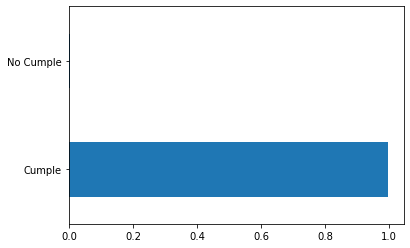

----------------------------------------------------------------------------------------------------------------
REGIONAL
 
CENTRO ORIENTE       0.697303
MAGDALENA MEDIO      0.066046
NORTE                0.062361
LLANOS ORIENTALES    0.057008
OCCIDENTE            0.054644
SUR                  0.052558
NO APLICA            0.010081
Name: Regional, dtype: float64


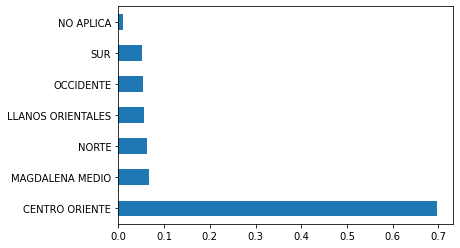

----------------------------------------------------------------------------------------------------------------
NOMBREUSUARIOSOLUCION
 
PAOLA ANDREA DAZA                          0.103657
EDGAR ANDRES GUZMAN HERNANDEZ              0.099068
CLAUDIA MARCELA PINEDA                     0.096496
JEIMY YOLIMA ARDILA PINZON                 0.095106
ANGIE CATHERINE BLANDON CACERES            0.094897
NATHALIA ROJAS CLAVIJO                     0.092394
JEIMY NATHALY GOMEZ GOMEZ                  0.091630
LINDA ALEJANDRA CAMACHO MURILLO            0.088223
ESTEFANIA GUZMAN AGUDELO                   0.076265
LAURA MAYERLY BOHORQUEZ GAMBA              0.068896
ADRIANA PATRICIA COMBITA ALFONSO           0.026766
MARTHA ELENA BELLO FORERO                  0.021691
ALEX LILIAN TOVAR ORTIZ                    0.018145
AMPARO DEL PILAR TORRES                    0.014600
NANCY GAMBA LÓPEZ                          0.011541
HARBEY WILFREDO CHAVARRIO ALVARADO         0.000417
CRISTHIAN FERNANDO  RONCANCIO C

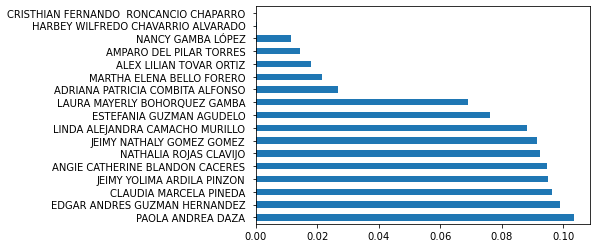

----------------------------------------------------------------------------------------------------------------
GRUPOROLSOLUCION
 
Asesor de Servicio BackOffice Contact Center    0.837736
Asesor de Servicio Contact Center               0.087250
Asesor solucionador Ecopetrol                   0.075014
Name: GrupoRolSolucion, dtype: float64


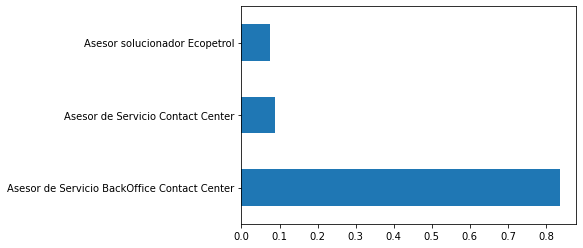

----------------------------------------------------------------------------------------------------------------
CUMPLE_OBJETIVO_ENNIVEL2
 
No Aplica    0.924986
Cumple       0.053184
No Cumple    0.021830
Name: Cumple_Objetivo_EnNivel2, dtype: float64


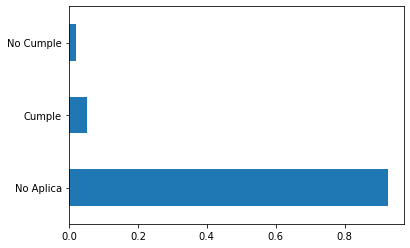

----------------------------------------------------------------------------------------------------------------
TIPIFICACIÓN
 
Contacto    0.924986
Atención    0.075014
Name: Tipificación, dtype: float64


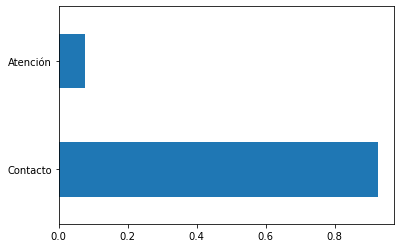

----------------------------------------------------------------------------------------------------------------
SIGLASDOCUMENTO
 
NIT    0.939029
CC     0.060762
TI     0.000070
CU     0.000070
RC     0.000070
Name: SiglasDocumento, dtype: float64


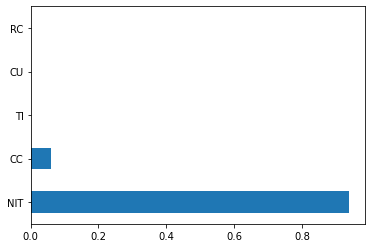

----------------------------------------------------------------------------------------------------------------
CANAL
 
Email BackOffice     0.525097
Telefónico           0.473721
Gestión Operativa    0.001182
Name: Canal, dtype: float64


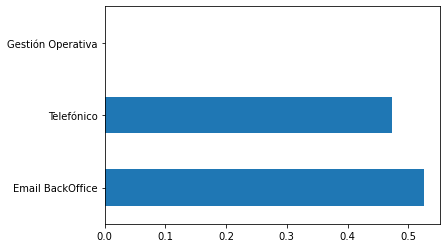

----------------------------------------------------------------------------------------------------------------
DEPARTAMENTO
 
BOGOTA             0.605812
SANTANDER          0.109080
META               0.040253
BOLIVAR            0.030659
CUNDINAMARCA       0.030381
HUILA              0.030033
ANTIOQUIA          0.029686
VALLE DEL CAUCA    0.022386
ATLANTICO          0.022316
PUTUMAYO           0.020231
CASANARE           0.016477
N. DE SANTANDER    0.011263
NO APLICA          0.010081
SUCRE              0.003615
BOYACA             0.003128
TOLIMA             0.002364
CORDOBA            0.002294
CALDAS             0.002225
CESAR              0.001877
MAGDALENA          0.001669
NARIÑO             0.001669
QUINDIO            0.000904
RISARALDA          0.000765
ARAUCA             0.000417
CAUCA              0.000417
Name: Departamento, dtype: float64


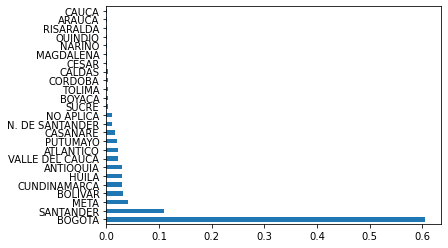

----------------------------------------------------------------------------------------------------------------
GRUPOROLCREACION
 
Asesor de Servicio BackOffice Contact Center    0.90559
Asesor de Servicio Contact Center               0.09441
Name: GrupoRolCreacion, dtype: float64


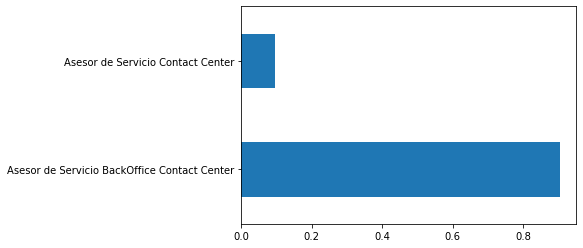

----------------------------------------------------------------------------------------------------------------
PAIS
 
Colombia                     0.989919
Estados Unidos de América    0.006813
México                       0.000487
Argentina                    0.000417
Canadá                       0.000348
Países Bajos                 0.000348
Micronesia                   0.000278
Francia                      0.000278
Brasil                       0.000278
Georgia                      0.000139
Australia                    0.000139
Monterrey                    0.000070
Panamá                       0.000070
Texas                        0.000070
Calgary                      0.000070
California                   0.000070
Perú                         0.000070
Minneapolis                  0.000070
Italia                       0.000070
Name: Pais, dtype: float64


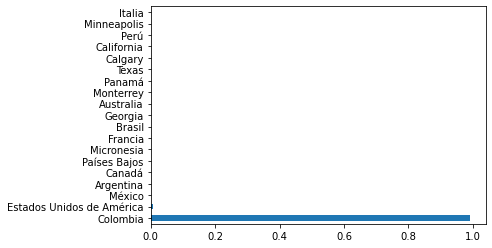

----------------------------------------------------------------------------------------------------------------
SISTEMAPAGO
 
Puesto de Trabajo    0.90559
Transacciones        0.09441
Name: SistemaPago, dtype: float64


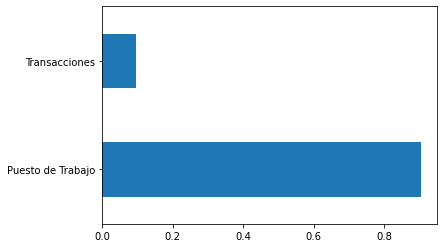

----------------------------------------------------------------------------------------------------------------
NIVEL3
 
Causación de facturas / Cockpit                                   0.723999
Radicación de facturas                                            0.151696
Información y Seguimiento a usuarios en página WEB Proveedores    0.094619
Endoso de facturas                                                0.012514
Consultas retenciones aplicadas                                   0.007091
Retención en Garantía                                             0.006605
Pagos bloqueados                                                  0.003476
Name: Nivel3, dtype: float64


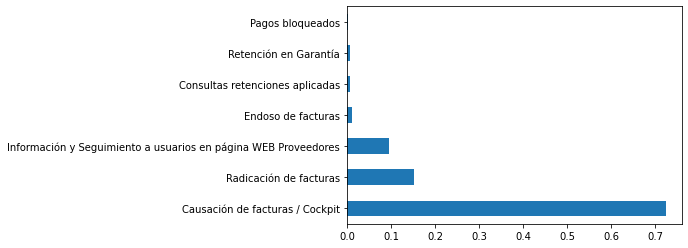

----------------------------------------------------------------------------------------------------------------
CUMPLE_OBJETIVO_SOLICITADOREGISTRADO
 
No Aplica    0.474903
No Cumple    0.388418
Cumple       0.136680
Name: Cumple_Objetivo_SolicitadoRegistrado, dtype: float64


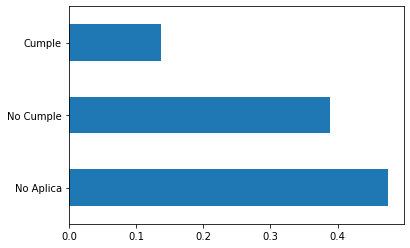

----------------------------------------------------------------------------------------------------------------
NOMBREUSUARIOGESTIONACTUAL
 
PAOLA ANDREA DAZA                          0.103657
EDGAR ANDRES GUZMAN HERNANDEZ              0.099068
CLAUDIA MARCELA PINEDA                     0.096496
JEIMY YOLIMA ARDILA PINZON                 0.095036
ANGIE CATHERINE BLANDON CACERES            0.094897
NATHALIA ROJAS CLAVIJO                     0.092394
JEIMY NATHALY GOMEZ GOMEZ                  0.091630
LINDA ALEJANDRA CAMACHO MURILLO            0.088223
ESTEFANIA GUZMAN AGUDELO                   0.076265
LAURA MAYERLY BOHORQUEZ GAMBA              0.068896
ADRIANA PATRICIA COMBITA ALFONSO           0.026766
MARTHA ELENA BELLO FORERO                  0.021691
ALEX LILIAN TOVAR ORTIZ                    0.018145
AMPARO DEL PILAR TORRES                    0.014600
NANCY GAMBA LÓPEZ                          0.011541
HARBEY WILFREDO CHAVARRIO ALVARADO         0.000417
CRISTHIAN FERNANDO  RONCAN

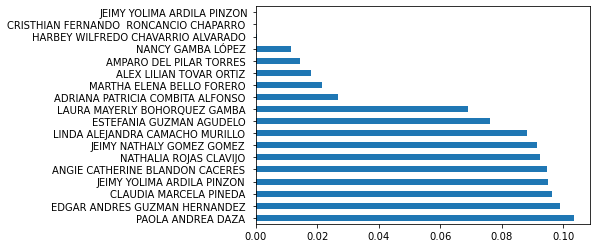

----------------------------------------------------------------------------------------------------------------
NOMBREUSUARIOCREACION
 
PAOLA ANDREA DAZA                          0.112556
CLAUDIA MARCELA PINEDA                     0.106090
EDGAR ANDRES GUZMAN HERNANDEZ              0.105047
NATHALIA ROJAS CLAVIJO                     0.102127
ANGIE CATHERINE BLANDON CACERES            0.101502
JEIMY NATHALY GOMEZ GOMEZ                  0.098860
JEIMY YOLIMA ARDILA PINZON                 0.098373
LINDA ALEJANDRA CAMACHO MURILLO            0.096844
ESTEFANIA GUZMAN AGUDELO                   0.084121
LAURA MAYERLY BOHORQUEZ GAMBA              0.075709
ALEX LILIAN TOVAR ORTIZ                    0.018423
CRISTHIAN FERNANDO  RONCANCIO CHAPARRO     0.000278
JEIMY YOLIMA ARDILA PINZON                 0.000070
Name: NombreUsuarioCreacion, dtype: float64


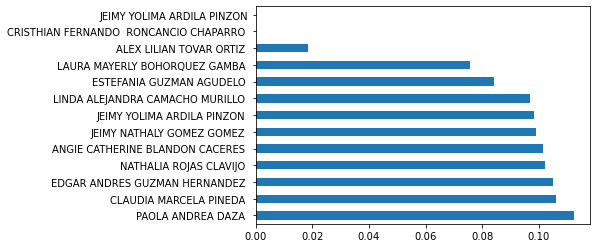

----------------------------------------------------------------------------------------------------------------
NOMBREGRUPOSOLUCION
 
Grupo Primer Nivel Operaciones Financieras    0.924986
Equipo de Causación                           0.075014
Name: NombreGrupoSolucion, dtype: float64


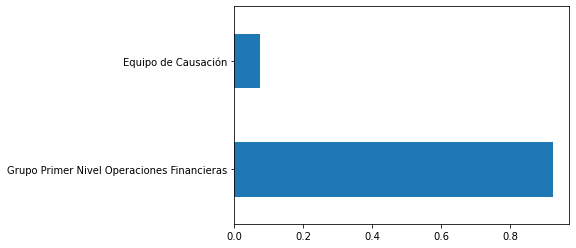

In [ ]:
for i in list(data.columns):
    print('----------------------------------------------------------------------------------------------------------------')
    print(i.upper())
    print (' ')
    univariado(data,i )

### **Columnas con observaciones**

In [ ]:
df['# Palabras_ObservacionCreacion'] = df['ObservacionCreacion'].str.split().str.len()
df['# Palabras_ObservacionSolucion'] = df['ObservacionSolucion'].str.split().str.len()
df['# Palabras_ObservacionCierre'] = df['ObservacionCierre'].str.split().str.len()


In [ ]:
df_Obser = df[['# Palabras_ObservacionCreacion', '# Palabras_ObservacionSolucion','# Palabras_ObservacionCierre' ]]
describe_var = df_Obser.describe().round(1)
describe_var = describe_var.append(pd.Series(df_Obser.var(), name = 'Variance')) 
describe_var = describe_var.append(pd.Series(df_Obser.sum(), name = 'Sum')) 

#descripcion_observ = df_OF_relevante[['# Palabras_fgs_ObservacionCreacion', '# Palabras_fgs_ObservacionSolucion','# Palabras_fgs_ObservacionCierre' ]].describe()
describe_var.round(1)

,# Palabras_ObservacionCreacion,# Palabras_ObservacionSolucion,# Palabras_ObservacionCierre
count,14384.0,14384.0,14384.0
mean,24.4,26.0,25.0
std,26.0,21.0,21.1
min,2.0,1.0,1.0
25%,6.0,12.0,10.0
50%,16.0,22.0,21.0
75%,32.2,34.0,34.0
max,259.0,355.0,355.0
Variance,676.9,439.9,444.3
Sum,350731.0,373568.0,359742.0


In [ ]:
describe_var.reset_index().to_csv('Informacion_general_observaciones_cuentaspagar.csv', index = False)

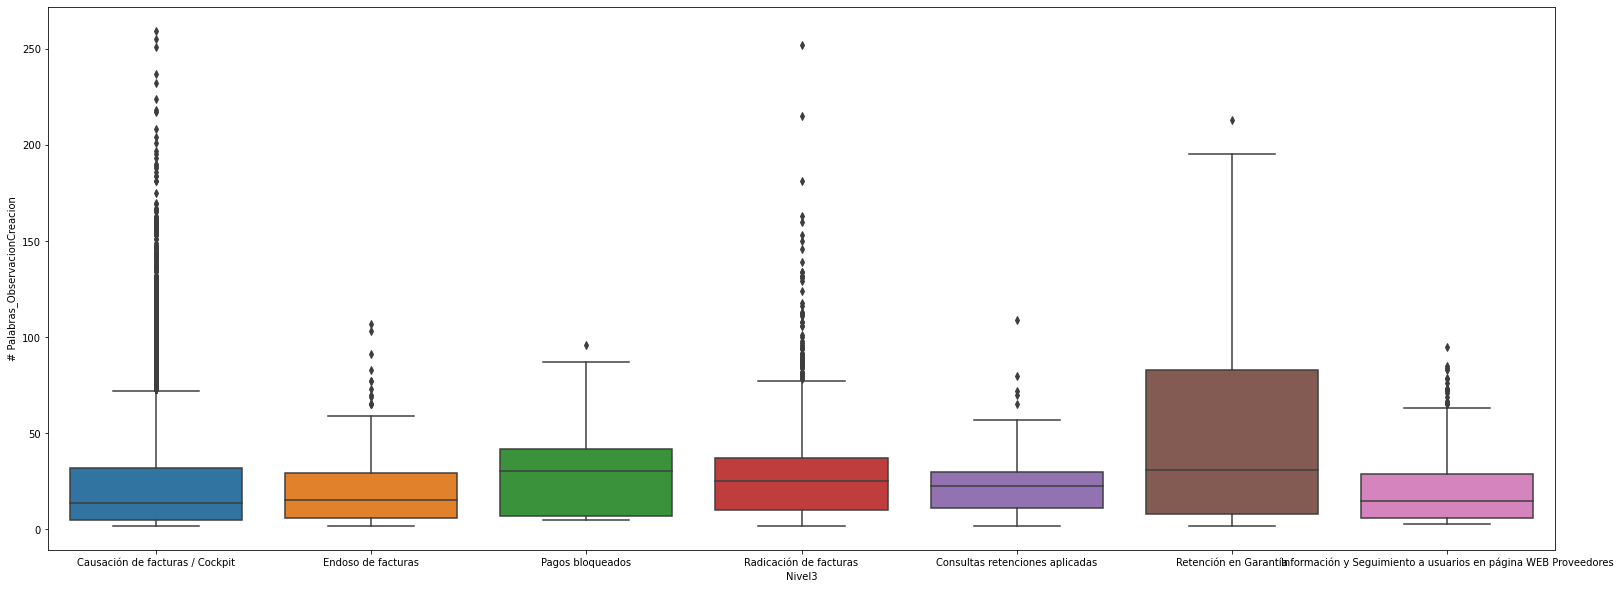

In [ ]:
plt.figure(figsize = (27,10))
sns.boxplot(x = df['Nivel3'], y = df['# Palabras_ObservacionCreacion'])
plt.show()

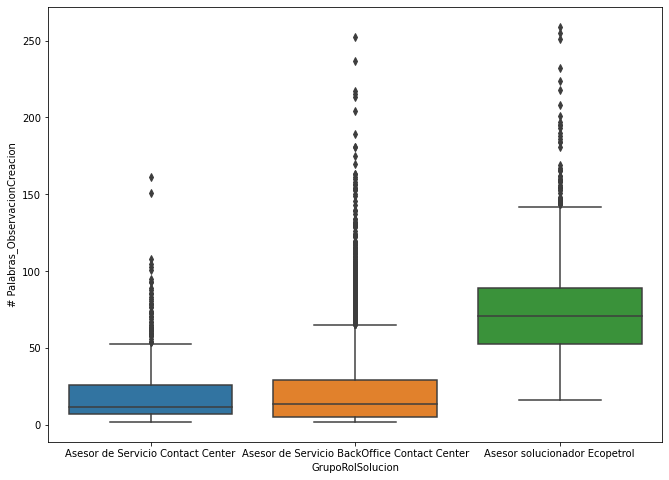

In [ ]:
plt.figure(figsize = (11,8))
sns.boxplot(x = df['GrupoRolSolucion'], y =df['# Palabras_ObservacionCreacion'])
plt.show()

**Porcentaje de palabras por nivel**

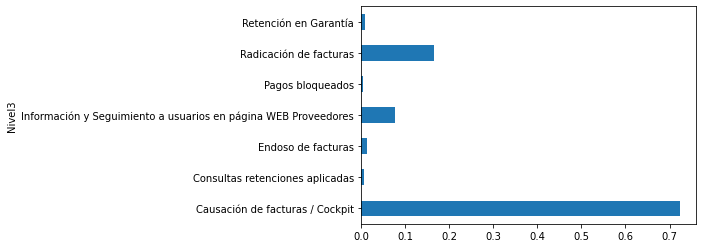

Nivel3
Causación de facturas / Cockpit                                   0.723254
Consultas retenciones aplicadas                                   0.006411
Endoso de facturas                                                0.014771
Información y Seguimiento a usuarios en página WEB Proveedores    0.077008
Pagos bloqueados                                                  0.004442
Radicación de facturas                                            0.165806
Retención en Garantía                                             0.008309
Name: % total_palabras, dtype: float64

In [ ]:
df['total_palabras']= df['# Palabras_ObservacionCreacion']+ df['# Palabras_ObservacionSolucion'] +df['# Palabras_ObservacionCierre']
df['% total_palabras'] = df['total_palabras']/df['total_palabras'].sum()
df['total_palabras'] = df['total_palabras'].fillna(0)
df.groupby('Nivel3')['% total_palabras'].sum().plot.barh()
plt.show()
df.groupby('Nivel3')['% total_palabras'].sum()

## **Análisis Multivariado**

In [ ]:
#Categorical Unordered Univariate Analysis* (https://towardsdatascience.com/exploratory-data-analysis-eda-python-87178e35b14)

In [ ]:
# Let's calculate the percentage of each job status category.
#data.job.value_counts(normalize=True)

#plot the bar graph of percentage job categories
#data.job.value_counts(normalize=True).plot.barh()
#plt.show()

### **Mapas de calor**

* Nivel_3 vs Grupo_Rol_Solución vs Total_palabras

Grupo_Rol_Solucion                                  Asesor de Servicio BackOffice Contact Center  \
Nivel_3                                                                                            
Causación de facturas / Cockpit                                                        71.435207   
Consultas retenciones aplicadas                                                        68.650000   
Endoso de facturas                                                                     89.853503   
Información y Seguimiento a usuarios en página ...                                     61.203306   
Pagos bloqueados                                                                       95.041667   
Radicación de facturas                                                                 83.877510   
Retención en Garantía                                                                  81.237288   

Grupo_Rol_Solucion                                  Asesor de Servicio Contact Center  \
Nivel_3   

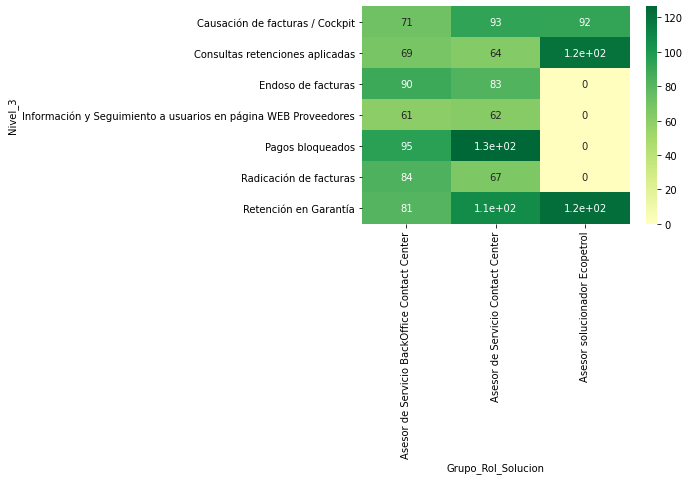

In [ ]:
result = pd.pivot_table(data=df, index='Nivel_3', columns='Grupo_Rol_Solucion',values='total_palabras', fill_value=0, aggfunc='mean')
print(result)

#create heat map of education vs marital vs response_rate
sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
plt.show()

* Nivel_3 vs Canal vs Total_palabras

Canal                                               Email BackOffice  \
Nivel_3                                                                
Causación de facturas / Cockpit                            84.104564   
Consultas retenciones aplicadas                            76.446429   
Endoso de facturas                                         94.397059   
Información y Seguimiento a usuarios en página ...         69.670902   
Pagos bloqueados                                           98.822222   
Radicación de facturas                                     86.684340   
Retención en Garantía                                      93.080460   

Canal                                               Gestión Operativa  \
Nivel_3                                                                 
Causación de facturas / Cockpit                             83.235294   
Consultas retenciones aplicadas                              0.000000   
Endoso de facturas                                         

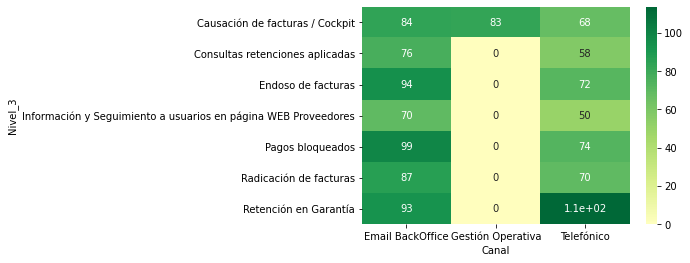

In [ ]:
result = pd.pivot_table(data=df, index='Nivel_3', columns='Canal',values='total_palabras', fill_value=0, aggfunc='mean')
print(result)

#create heat map of education vs marital vs response_rate
sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
plt.show()

### **Análisis de correspondencias multiples MCA**

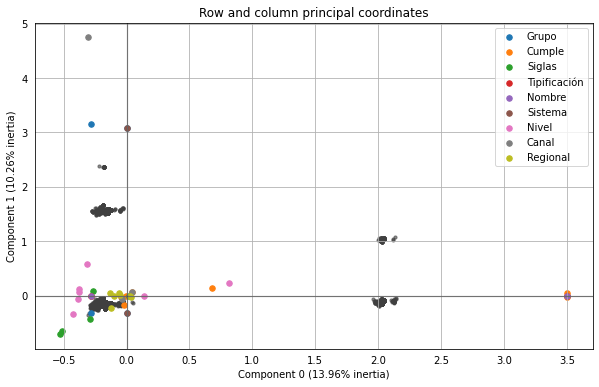

In [ ]:
columnas = list(df_columnasCat[(df_columnasCat['#valores dintintos'] <= 10)].Nombre_columna)
X = df[columnas]
mca = prince.MCA()
mca = mca.fit(X)
mca1 = mca.transform(X) 
#print(mca1)
ax = mca.plot_coordinates(
     X=X,
     ax=None,
     figsize=(10, 6),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
     )